# Lab 8: Implement Your Machine Learning Project Plan

I chose the twitter sentiment analysis dataset becasue I wanted to expand upon NLP and learn more about deep neural networks. 

I found that most of the tweets in my dataset were actually reviews of different products, video games, and web services so a model like this could be further implememented by companies to gague public reception of their new products on social media. For twitter itself, this model could be used to determine which products users like and which ads to run on the site

The overall structure of my model is word embeddings that are mapped to tokens and fed into a recurrent neural network. The word embeddings are input using an embedding layer, it goes through 2 LSTM layers and then an output layer.
I wanted to use word embeddings because they aren't sparse like other vectorizers and uitilzes the semantic context between each word through cosine similarity.

Because what I wanted to do was a bit out of the scope of what we covered in class, I used the following resources to create a shell for my model and figure out how to process word embeddings: 
<a href="https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456">word embeddings tutoiral</a>
<a href="https://www.google.com/url?q=https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test&sa=D&source=docs&ust=1691811932916951&usg=AOvVaw04Jx8dffs2JwJipeaD3cKQ">how to split data into a val set</a>
<a href="https://keras.io/guides/working_with_rnns/#:~:text=model%20%3D%20keras.Sequential%28%29%20%23%20Add%20an%20Embedding%20layer,a%20Dense%20layer%20with%2010%20units.%20model.add%28layers.Dense%2810%29%29%20model.summary%28%29">Keras RNN Documentation</a>
<a href="https://danijar.com/tips-for-training-recurrent-neural-networks/">Optimizing</a>
<a href="https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/">LSTM</a>
<a href="https://www.bing.com/search?q=gru+layers+in+rnn&cvid=d4fca12d48024661902a22055ced9c00&aqs=edge.0.69i59j69i57j0l5j46j69i60.1461j0j9&FORM=ANAB01&PC=U531">GRU</a>

### Import Packages

Before you get started, import a few packages.

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install --upgrade scikit-learn
%pip install --upgrade tensorflow
%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need for this task.

In [5]:
%pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
click                        8.1.6
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7.post1
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.5.26
fonttools                    4.42.0
gast                         0.4.0
gensim                       4.3.1
google-auth                  2.22.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.57.0
h5py                         3.9.0
idna                         3.4
ipykernel                    6.25


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# YOUR CODE HERE
import tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import keras as keras
import time
from sklearn.metrics import roc_auc_score
from keras import layers
import gensim



## Part 1: Load the Data Set


Dataset Source: <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis">Kaggle</a>
The orginial dataset had an id, an entity the tweet was about, the tweet itself, and the sentiment attached to the tweet. The original challenge was to do sentiment analysis based on the entity the tweet was about however I wanted to conduct an analysis based on the text in the tweet. Also the sentiments were either postivie, neutral, or negative but to simplify I only used the positive and negative tweets.

In [7]:
# YOUR CODE HERE
filename = os.path.join(os.getcwd(), "twitter_training.csv")
df_og = pd.read_csv(filename, header=0)

In [8]:

df = df_og[['is_Positive', 'Review']]
df = df[(df['is_Positive'] == 'Positive') | (df['is_Positive'] == 'Negative')]





## Part 2: Exploratory Data Analysis


This step will help you determine data preparation and feature engineering techniques you will need to apply to your data to build a balanced modeling data set for your problem and model. These data preparation techniques may include:
* addressing missingness, such as replacing missing values with means
* renaming features and labels
* finding and replacing outliers
* performing winsorization if needed
* performing one-hot encoding on categorical features
* performing vectorization for an NLP problem
* addressing class imbalance in your data sample to promote fair AI


<h2>EDA</h2>
I made it so the dataset only contained the columns sentiment and tweet and then took out any tweet with the sentiment Neutral so I could have binary values for the sentiment column. The values for the is_Positive (sentiment) column were now 'Positive' and 'Negative' but I used pd.apply to map those values to binary numbers.

 Checked for class imbalance and dropped any null values, I didn't modify null values because the dataset was so large to begin with. (Around 40k examples)

In [9]:

df.drop(df[df.Review ==  'Neutral'].index, inplace=True)
def map_sentiment(sentiment):
    if sentiment == 'Positive':
        return 1
    if sentiment == 'Negative':
        return 0
    else:
        raise ValueError("Unknown sentiment: " + sentiment)

df['is_Positive'] = df['is_Positive'].apply(map_sentiment)

print('are there any null values?', df.isna().any())
print('\n')
df.dropna(inplace=True)
#I just dropped the rows that have null values
print(df.isna().any())

are there any null values? is_Positive    False
Review          True
dtype: bool


is_Positive    False
Review         False
dtype: bool


In [10]:
print('how many negative reviews are there:', df['is_Positive'].value_counts()[0])
print('how many positive reviews are there:', df['is_Positive'].value_counts()[1])
print('in my opinion theres little class imbalance cuz theres only 2000 more negative reviews than positive')


how many negative reviews are there: 22358
how many positive reviews are there: 20655
in my opinion theres little class imbalance cuz theres only 2000 more negative reviews than positive


In [11]:
df.head()


,is_Positive,Review
0,1,im getting on borderlands and i will murder yo...
1,1,I am coming to the borders and I will kill you...
2,1,im getting on borderlands and i will kill you ...
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands 2 and i will murder ...


<h2>Possible Bias in Dataset </h2>
I noticed the number of positive reviews with male pronouns was double
the amount of positive reviews with female pronouns, implying there's more positive reviews for products/services involving men.
I decided to use gendered pronouns as a stopwords list to clean the data with to prevent gender bias as a preventative measure.
If I hadn't the model could fall into allocative bias, not recommending products/services for/by women.

In [12]:
female_pronouns = [ 'she', 'her']
male_pronouns = ['he', 'him', 'his']

# Combine the target words into a regular expression pattern
m_pattern = r'\b(?:' + '|'.join(male_pronouns) + r')\b'
f_pattern =  r'\b(?:' + '|'.join(female_pronouns) + r')\b'

male_df = df[df['Review'].str.contains(m_pattern, case=False, na=False)]
female_df = df[df['Review'].str.contains(f_pattern, case=False, na=False)]
print('how many reviews with male pronouns that are positive:', (male_df['is_Positive'] == 1).sum())
print('how many reviews with female pronouns are positive:',(female_df['is_Positive'] == 1).sum())

how many reviews with male pronouns that are positive: 402
how many reviews with female pronouns are positive: 247


In [13]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sofia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sofia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Preprocess Data and Tokenize it</h2>
While cutting stopwords usually improves model performance, I noticed that the more stopwords I excluded, the worse the model performed, this could be because I'm not working with very long documents (each review is a paragraph each) or because the word vectors/ RNN are able to better use the context of stopwords to make predictions.
So i only took out the gendered pronouns

In [15]:
review_lines = []  # Initialize the list to store cleaned lines exmpale:: ['im', 'totally', 'getting', 'this', 'game']

# Preprocess the lines using simple_preprocess and remove stop words
lines = df['Review']
stop_words = ['he', 'his', 'him', 'she', 'her', 'hers']

for line in lines:
    
    cleaned_line = [word for word in gensim.utils.simple_preprocess(line) if word not in stop_words]
    review_lines.append(cleaned_line)
    
    

print('how many examples : ',len(review_lines))


how many examples :  43013


<h2>Creating the Word Embeddings Using Word2Vec</h2>

In [16]:
EMBEDDING_DIM = 100
model = gensim.models.Word2Vec(sentences = review_lines, vector_size = EMBEDDING_DIM, window = 8, workers = 4, min_count = 1)
words = list(model.wv.key_to_index)
print('vocabulary size', len(words))

vocabulary size 18710


In [17]:
model.wv.most_similar('trilogy')

[('standard', 0.8962534666061401),
 ('possibly', 0.8725541830062866),
 ('perhaps', 0.8694287538528442),
 ('nintendo', 0.8499842882156372),
 ('fortnites', 0.847375214099884),
 ('newly', 0.844363808631897),
 ('seventh', 0.8441952466964722),
 ('inside', 0.8410889506340027),
 ('amongst', 0.8410755395889282),
 ('trailers', 0.8371947407722473)]

<h2>Creating a Dictionary With Word:Vector Pairs</h2>
Save the model into a text file which is the word and then a 100 length vector for each line
model is saved into a txt file then iterated line by line to tokenize (split up) the word from the values
embeddings_dictionary is {word_in_review : 100_num_vector}

In [18]:
#load the wordembeddings as a dict of words to vectors
filename = 'twitter_training_word2vec.txt'
model.wv.save_word2vec_format(filename, binary = False)
embeddings_dictionary = {}
f = open(os.path.join('', 'twitter_training_word2vec.txt'), encoding = 'utf-8')
#embeddings_dictionary one line of f is the word corresponding with a long integer vector
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_dictionary[word] = coefs
f.close()


You can't just put the word vectors straight into a neural network 
so they need to be tokenized and put into an embedding layer rather than as input for like a normal dense layer

In [19]:
#convert word embedding into a tokenized vector. maps to the index of a single vector in the embeddings layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
#tokenize (split up) each word in the total vocabulary with tokenizer_obj
sequences = tokenizer_obj.texts_to_sequences(review_lines)
#Each integer in these sequences represents a token from the original text. Returns sequences of integers
# This is typically done by mapping each token to a unique integer based on the tokenizer's internal vocabulary


word_index = tokenizer_obj.word_index
#word index is like a dictionary of a word and a number 1-20843
review_pad = pad_sequences(sequences, maxlen = 100)
#so in each index of review pad is a bunch of numbers based on the embeddings
# theres always 100 numbers at each index because thats what maxlen is
#if vector is <100 then add 0s
is_Positive = df['is_Positive'].values
#max_len is a tunable hyperparameter



In [20]:
#so now were mapping the embeddings from word2vec to the tokenized vocab to make a matrix
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    
#embedding_matrix is the final var that you input into the embedding layer in final model

## Part 3: Implement Your Project Plan


1. Prepare your data for your model and create features and a label.
2. Fit your model to the training data and evaluate your model.
3. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.

Now Im going to create the neural net starting with an embedding layer that will take in our sequences/embeddings/dictionary/matrices. Also make a grid search algorithmn to find the best hyperparameters.

In [21]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU 
#those are diff types of rnn layers

from keras.initializers import Constant
from keras.metrics import AUC, Precision


<h2>What are the RNN Layers?</h2>
<ul>
    <li>Embedding - maps input information from a high-dimensional to a lower-dimensional space</li>
<li>LSTM - Solves the vanishing gradient problem (gradient becomes too small to update weights) cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the layer. theres a memory cell, Forget gate, input and output gates</li>
<li>GRU - Like LSTM but fewer parameters and lacks an output gate. Reset and update gates no long range memory cell</li>
</ul>

Now I'm going to do a train/val/split where validation set is 20% of the total data
basically u take the review_pad sequence, randomize all the indices and the data up

In [23]:
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
is_Positive = is_Positive[indices]


#so idk how to get 3 splits with train_test_split so i did two test train splits on top of each other

X, X_test, y, y_test = train_test_split(review_pad,is_Positive,test_size=0.2,train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,train_size =0.75)

In [24]:
%pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<h2> Performing A Grid Search For Best Params </h2>
I'm trying to optimize the number of units for each layer, the optimizer function (Learning rate), and the dropout rate.

Note:: The grid search took forever so I could really only look for two hyperparameters at a time

In [25]:

%pip install tensorflow scikeras scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [266]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.base import BaseEstimator
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.initializers import Constant
from keras.metrics import AUC

# Define your build_clf function
def build_clf(learning_rate1, units1, units2):
    model = Sequential()
    
    # Add an embedding layer
    embedding_layer = Embedding(input_dim=num_words, output_dim=EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=100, trainable=False)
    model.add(embedding_layer)
    
    # Add two LSTM layers with the specified number of units
    model.add(LSTM(units=units1, dropout=.4, recurrent_dropout=.4, return_sequences=True))
    model.add(LSTM(units=units2, dropout=.2, recurrent_dropout=.4))
    
    # Add a dense output layer
    model.add(Dense(1, activation='sigmoid'))
    optimizer_func = keras.optimizers.Adam(learning_rate = learning_rate1)
    model.compile(loss='binary_crossentropy', optimizer=optimizer_func, metrics=[AUC()])
    return model

# Define a wrapper class for Keras model to work with GridSearchCV because the keras.wrapper.gridsearch wasn't importing for the life of me...
class KerasGridSearchWrapper(BaseEstimator):
    def __init__(self, learning_rate1 = .001, units1 = 16, units2 = 16):
        self.learning_rate1 = learning_rate1
        self.units1 = units1
        self.units2 = units2
        self.model = None

    def fit(self, X, y):
        self.model = build_clf(learning_rate1 = self.learning_rate1, units1 = self.units1, units2 = self.units2)
        self.model.fit(X, y, epochs=5, batch_size=128)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define hyperparameter grid I kept changing this
param_grid = {
    "learning_rate1": np.arange(.001, .011, .005),
    "units1": np.arange(16,128,16),
    "units2":np.arange(16,128,16)
}

# Create scoring metric
scoring = make_scorer(roc_auc_score)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=KerasGridSearchWrapper(), param_grid=param_grid, scoring=scoring, cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Display results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/5
7/7 [==============================] - 9s 228ms/step - loss: 0.6959 - auc_925: 0.4871
Epoch 2/5
7/7 [==============================] - 2s 276ms/step - loss: 0.6931 - auc_925: 0.5161
Epoch 3/5
7/7 [==============================] - 3s 411ms/step - loss: 0.6922 - auc_925: 0.5454
Epoch 4/5
7/7 [==============================] - 3s 396ms/step - loss: 0.6940 - auc_925: 0.5116
Epoch 5/5
13/13 [==============================] - 2s 49ms/step
Epoch 1/5
7/7 [==============================] - 21s 422ms/step - loss: 0.6911 - auc_926: 0.5390
Epoch 2/5
7/7 [==============================] - 3s 423ms/step - loss: 0.6907 - auc_926: 0.5457
Epoch 3/5
7/7 [==============================] - 3s 402ms/step - loss: 0.6920 - auc_926: 0.5440
Epoch 4/5
7/7 [==============================] - 3s 416ms/step - loss: 0.6876 - auc_926: 0.5739
Epoch 5/5
13/13 [==============================] - 2s 46ms/step
Epoch 1/5
7/7 [==============================] - 24s 431ms/step - loss: 0.6898 - auc_927: 0.5301
Epoch 

KeyboardInterrupt: 

<h1> Creating the Final Model </h1>
<h3>Why I chose the Layer Type </h3>
The LSTM is more complex than GRU because it has more gates and a memory cell that can better contextualize words in a document in long range dependencies
<h3>Why I Chose the AUC Metric</h3>
Because this model can be used for a recommender system, its worse to have a false positive than a false negative because you dont want to recommend a book thats disliked by readers. Because of that I ruled out recall. AUC is the amount of true positives over false positives, AUC also takes into account the probability that each prediction will be right so I chose AUC as my metric seems to be better for classifying text data than precision is.



In [26]:
model = Sequential()
embedding_layer = Embedding(num_words, EMBEDDING_DIM, 
                           embeddings_initializer = Constant(embedding_matrix),
                           input_length = 100,
                           trainable = False)
model.add(embedding_layer)
model.add(LSTM(units=16, dropout = .40, recurrent_dropout = .40, return_sequences = True))

model.add(LSTM(units=128, dropout = .20, recurrent_dropout = .40))
model.add(Dense(1, activation = 'sigmoid'))

optimizer_func = keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='binary_crossentropy', optimizer=optimizer_func, metrics=[AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1871100   
                                                                 
 lstm (LSTM)                 (None, 100, 16)           7488      
                                                                 
 lstm_1 (LSTM)               (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1952957 (7.45 MB)
Trainable params: 81857 (319.75 KB)
Non-trainable params: 1871100 (7.14 MB)
_________________________________________________________________


Theres a lot less trainable params than total params because I created  the word embeddings dictionary
myself so in theory this will make it all train faster.



In [52]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
print('begin training process')
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=10, verbose=1, min_lr=1e-6)
#callbacks = [lr_scheduler]
model.fit(X_train, y_train, batch_size = 48, epochs = 50, validation_data=(X_val, y_val), 
         verbose = 2)
print('\n training process done!!')

begin training process
Epoch 1/50
538/538 - 181s - loss: 0.5427 - auc: 0.8012 - val_loss: 0.4921 - val_auc: 0.8464 - lr: 0.0010 - 181s/epoch - 336ms/step
Epoch 2/50
538/538 - 183s - loss: 0.4935 - auc: 0.8413 - val_loss: 0.4625 - val_auc: 0.8628 - lr: 0.0010 - 183s/epoch - 340ms/step
Epoch 3/50
538/538 - 190s - loss: 0.4731 - auc: 0.8552 - val_loss: 0.4569 - val_auc: 0.8683 - lr: 0.0010 - 190s/epoch - 353ms/step
Epoch 4/50
538/538 - 178s - loss: 0.4618 - auc: 0.8626 - val_loss: 0.4492 - val_auc: 0.8735 - lr: 0.0010 - 178s/epoch - 331ms/step
Epoch 5/50
538/538 - 175s - loss: 0.4562 - auc: 0.8663 - val_loss: 0.4417 - val_auc: 0.8757 - lr: 0.0010 - 175s/epoch - 325ms/step
Epoch 6/50
538/538 - 180s - loss: 0.4502 - auc: 0.8698 - val_loss: 0.4344 - val_auc: 0.8802 - lr: 0.0010 - 180s/epoch - 334ms/step
Epoch 7/50
538/538 - 172s - loss: 0.4443 - auc: 0.8734 - val_loss: 0.4354 - val_auc: 0.8826 - lr: 0.0010 - 172s/epoch - 319ms/step
Epoch 8/50
538/538 - 172s - loss: 0.4386 - auc: 0.8767 - val

Epoch 1/50
538/538 - 199s - loss: 0.4246 - auc: 0.8850 - val_loss: 0.4223 - val_auc: 0.8878 - 199s/epoch - 369ms/step
Epoch 2/50
538/538 - 199s - loss: 0.4241 - auc: 0.8856 - val_loss: 0.4261 - val_auc: 0.8868 - 199s/epoch - 370ms/step
Epoch 3/50
538/538 - 201s - loss: 0.4164 - auc: 0.8898 - val_loss: 0.4219 - val_auc: 0.8897 - 201s/epoch - 374ms/step
Epoch 4/50
538/538 - 199s - loss: 0.4157 - auc: 0.8902 - val_loss: 0.4134 - val_auc: 0.8924 - 199s/epoch - 370ms/step
Epoch 5/50
538/538 - 184s - loss: 0.4104 - auc: 0.8930 - val_loss: 0.4123 - val_auc: 0.8936 - 184s/epoch - 342ms/step
Epoch 6/50
538/538 - 174s - loss: 0.4086 - auc: 0.8940 - val_loss: 0.4065 - val_auc: 0.8953 - 174s/epoch - 324ms/step
Epoch 7/50
538/538 - 172s - loss: 0.4042 - auc: 0.8965 - val_loss: 0.4099 - val_auc: 0.8956 - 172s/epoch - 320ms/step
Epoch 8/50
538/538 - 178s - loss: 0.4018 - auc: 0.8979 - val_loss: 0.4018 - val_auc: 0.8983 - 178s/epoch - 330ms/step
Epoch 9/50
538/538 - 172s - loss: 0.3982 - auc: 0.8997 -

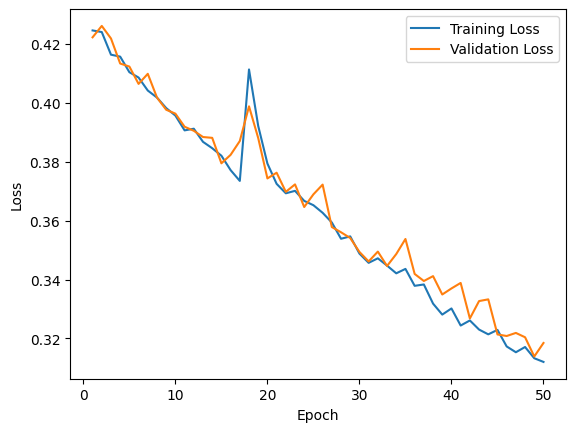

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=48, verbose = 2)

plt.plot(range(1, 50 + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, 50 + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, auc = model.evaluate(X_test, y_test)


print('Loss: ', str(loss) , 'Auc: ', str(auc))

269/269 [==============================] - 6s 23ms/step - loss: 0.3098 - auc: 0.9413
Loss:  0.3097611665725708 Auc:  0.9412671327590942


<h1>Conclusion, Challenges, And What I Would Improve</h1>

Overall I'm really happy with how this model turned out, orginailly this was supposed to be with book data reviews but that had much less data and I ended up with only a few thousand trainable params by the end of it, because I didn't have much data my model had a lot of bias and wasn't performing well.

I wanted to prove the concept of using word embeddings in a recurrent neural network so I'm glad that I changed the dataset.

<h3>Biggest Challenge</h3>
My biggest challenge with this problem was for the gridsearch function when I was trying to build the shell of the model that I would use in the gridsearch, I couldn't get the kerasClassifer to import to create a the estimator model so I had to create a function myself that during the training process would assign a blank model different hyperparameters to try out and see which combination is best. 

<h2>Things to improve.......</h2>


I originally used lr_scheduling which decreases the learning rate by 5% if the validation loss doesn't improve over 10 epochs, howeveer the val_loss was improving anyways over 10 epochs so there wasn't really a need to add it and it made training time exponentially longer. 

In general I think this model took far too long to train (several hours) so I would probably look into how much I can downsample the data without sacrificing performance (paralell processing isn't available for me because im on a laptop thats not very powerful)

I would like to add batch normalization (whcihc rescales the input data to have a mean of 0 and sd of 1) this is supposed to make training much faster because now it takes around 10 hours to train this model. Batch normalization mititgates internal covariate shift (all input has different distrivutions and it takes time to account for that in the model)

